In [2]:
from astropy.io import fits
from astropy.modeling import models, fitting

import numpy as np
from scipy import optimize
from pathlib import Path
import matplotlib.pyplot as plt

import scipy.stats as stats
from lmfit.models import GaussianModel 
import pprint

In [3]:
#data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_0_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")
#data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_35_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")
#data_path = Path("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-12-09\BC001_Al_FF_243K_HORI_10_0\Analysis\imaging_analysis_20241213\image_reconstruction.fits.gz")
#data_path = Path("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-12-12\BC057_Ti_FF_233K_HORI_0_0\Analysis\imaging_analysis_20241213\image_reconstruction.fits.gz")
#data_path = Path("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-12-12\BC057_Ti_FF_233_HORI_0_0\Analysis\imaging_analysis_20241213\image_reconstruction.fits.gz")
#data_path = Path("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-11-18\BC_Ti_EffArr_1_R04\Analysis\imaging_analysis_20241120\image_reconstruction.fits.gz")
data_path = Path(r"Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-12-09\BC001_Al_FF_243K_HORI_10_0\Analysis\imaging_analysis_20241213\image_reconstruction.fits.gz") 

d = fits.open(data_path) # open fits file

data = d[0].data # data contents of the fits file
shape =  data.shape
imPixelSize = 0.0149

y = imPixelSize * np.linspace((shape[0]-1)/-2,(shape[0]-1)/2, shape[0]) # create array from -23 deg to 23 deg, centered on zero
x = imPixelSize * np.linspace((shape[1]-1)/-2,(shape[1]-1)/2, shape[1]) # create array from -41 deg to 41 deg, centered on zero

peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 10

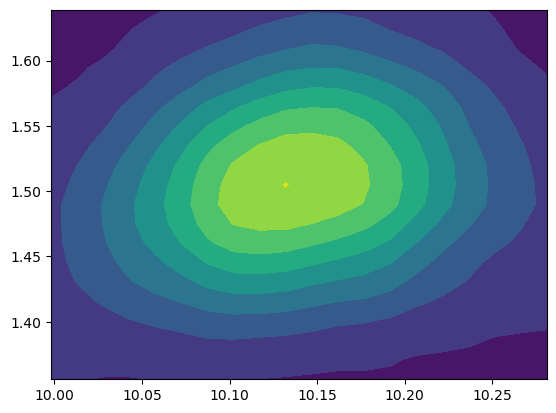

In [4]:
x_window =x[peak_loc[1]-window:peak_loc[1]+window]
y_window =y [peak_loc[0]-window:peak_loc[0]+window]
X,Y = np.meshgrid(x[peak_loc[1]-window:peak_loc[1]+window],y[peak_loc[0]-window:peak_loc[0]+window])
windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]

plt.contourf(-X, Y, windowed_data)
plt.savefig('2dpeak')




In [4]:
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt

def fit_rotated_2d_gaussian(data, x=None, y=None, plot_result=False):
    """
    Fit a rotated 2D Gaussian to 2D data using Astropy's Gaussian2D model.

    Parameters:
        data : 2D numpy array
            The input data array to fit.
        x, y : 2D numpy arrays, optional
            Meshgrid coordinates corresponding to data. If None, will be auto-generated.
        plot_result : bool
            Whether to plot the original data and fit result.

    Returns:
        fitted_model : Gaussian2D
            The best-fit Gaussian2D model.
    """
    # Generate coordinate grids if not provided
    ny, nx = data.shape
    if x is None or y is None:
        y, x = np.mgrid[:ny, :nx]

    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]

    # Initial guess for model
    gauss_init = models.Gaussian2D(amplitude=amplitude_init, x_mean=x_mean_init,
                                   y_mean=y_mean_init, x_stddev=.01, y_stddev=.01, theta=1)

    # Fitting with Levenberg-Marquardt algorithm
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gauss_init, x, y, data)
    covariance_matrix = fitter.fit_info['param_cov']

    if plot_result:
        fit_data = fitted_model(x, y)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].contour(x,y,data, origin='lower', cmap='viridis')
        axes[0].set_title("Original Data")
        axes[1].contour(x,y,fit_data, origin='lower', cmap='viridis')
        axes[1].set_title("Fitted Gaussian")
        plt.tight_layout()
        plt.show()

    return fitted_model,covariance_matrix


# Generate synthetic Gaussian data
def generate_rotated_gaussian_data(amp,xmean,ymean,xstd,ystd,theta):
    y, x = np.mgrid[0:100, 0:100]
    model = models.Gaussian2D(amplitude=3, x_mean=50, y_mean=50,
                              x_stddev=10, y_stddev=20, theta=np.pi/4)
    data = model(x, y) + 0.1 * np.random.normal(size=x.shape)
    return data, x, y

c:\Users\ajo5182\AppData\Local\miniconda3\envs\xhcd\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


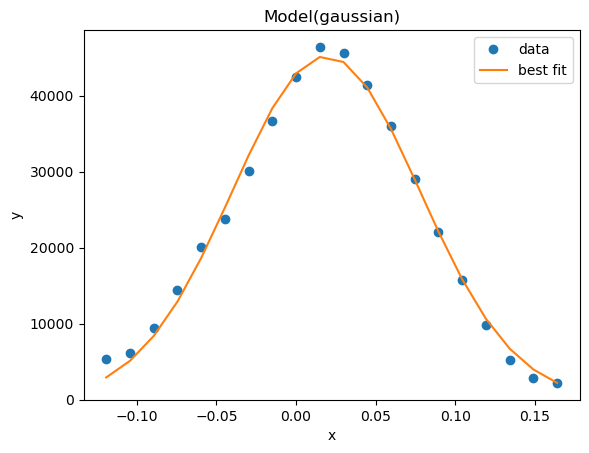

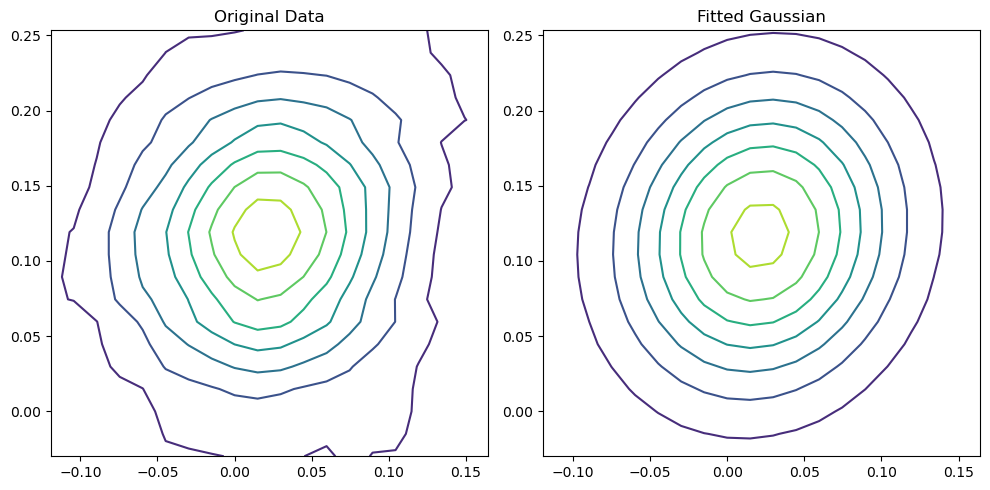

Amplitude: 44450.25379880238
x_mean: 0.02132841789602008
y_mean: 0.11682582871363775
x_stddev: 0.057890024254291586
y_stddev: 0.0680259921760892
theta (radians): -0.2996585635534015


In [5]:
def fit_rotated_2d_gaussian(data, x=None, y=None, plot_result=False):
    """
    Fit a rotated 2D Gaussian to 2D data using Astropy's Gaussian2D model.

    Parameters:
        data : 2D numpy array
            The input data array to fit.
        x, y : 2D numpy arrays, optional
            Meshgrid coordinates corresponding to data. If None, will be auto-generated.
        plot_result : bool
            Whether to plot the original data and fit result.

    Returns:
        fitted_model : Gaussian2D
            The best-fit Gaussian2D model.
    """
    # Generate coordinate grids if not provided
    ny, nx = data.shape
    if x is None or y is None:
        y, x = np.mgrid[:ny, :nx]

    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]

    xcut =x[:][int(ny/2)]
    guessModel = GaussianModel()
    params = guessModel.guess(xcut, data[:][int(ny/2)])
    guessResult = guessModel.fit(data[:][int(ny/2)], params,x = xcut)
    guessResult.plot_fit()

    # Initial guess for model
    gauss_init = models.Gaussian2D(amplitude=amplitude_init, x_mean=x_mean_init,
                                   y_mean=y_mean_init, x_stddev=guessResult.params['sigma'].value, y_stddev=guessResult.params['sigma'].value, theta =0)
    
    #gauss_init = models.Lorentz2D(amplitude=amplitude_init, x_0=x_mean_init,
    #                               y_0=y_mean_init, fwhm = 2.35*guessResult.params['sigma'].value)
    

    # Fitting with Levenberg-Marquardt algorithm
    #fitter = fitting.LevMarLSQFitter(calc_uncertainties=False)
    fitter = fitting.DogBoxLSQFitter()

    fitted_model = fitter(gauss_init, x, y, data,weights=10 *data)
    covariance_matrix = fitter.fit_info['param_cov']
    param_names = fitted_model.param_names
    param_errors = np.sqrt(np.diag(covariance_matrix))
    fit_data = fitted_model(x, y)
    if plot_result:
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].contour(x,y,data, origin='lower', cmap='viridis')
        axes[0].set_title("Original Data")
        axes[1].contour(x,y,fit_data, origin='lower', cmap='viridis')
        axes[1].set_title("Fitted Gaussian")
        plt.tight_layout()
        plt.show()
    
    return fitted_model,covariance_matrix,param_errors,fit_data



fitted,cov,param_errors, fit_data= fit_rotated_2d_gaussian(windowed_data, -X, Y,True)

# Print the fitted parameters
print(f"Amplitude: {fitted.amplitude.value}")
print(f"x_mean: {fitted.x_mean.value}")
print(f"y_mean: {fitted.y_mean.value}")
print(f"x_stddev: {fitted.x_stddev.value}")
print(f"y_stddev: {fitted.y_stddev.value}")
print(f"theta (radians): {fitted.theta.value}")
#print(f"rmse {np.sqrt(np.mean(((windowed_data/np.max(windowed_data)-fit_data/np.max(fit_data))**2)))}")



Amplitude: 42315.89747542596
x_mean: 0.021104819439497654
y_mean: 0.11702119882801332
x_stddev: 0.061647829623126746
y_stddev: 0.07209319246809284
theta (radians): -0.2788982897056676

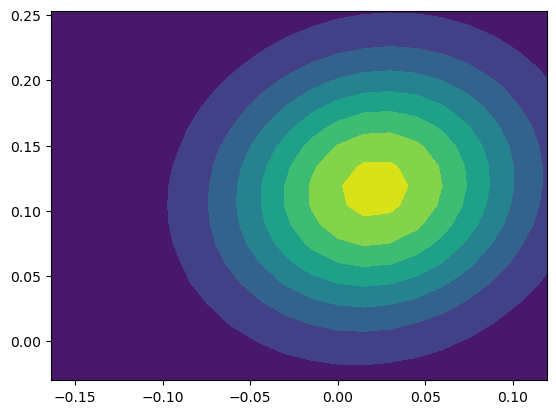

In [12]:
def generate_rotated_gaussian_data(x,y,amp,xmean,ymean,xstd, ystd,theta):
    #y, x = np.mgrid[0:100, 0:100]
    model = models.Gaussian2D(amp,xmean,ymean,xstd, ystd,theta)
    data = model(x, y)
    return data

test = generate_rotated_gaussian_data(X,Y, fitted.amplitude.value, fitted.x_mean.value,fitted.y_mean.value,fitted.x_stddev.value,fitted.y_stddev.value,fitted.theta.value)
plt.contourf(X,Y,test)
win_0 = np.where(windowed_data<0,0,windowed_data)
test = np.where(test<0,0,test)
dat = [win_0, test]


#print(stat,p,dof,expected)


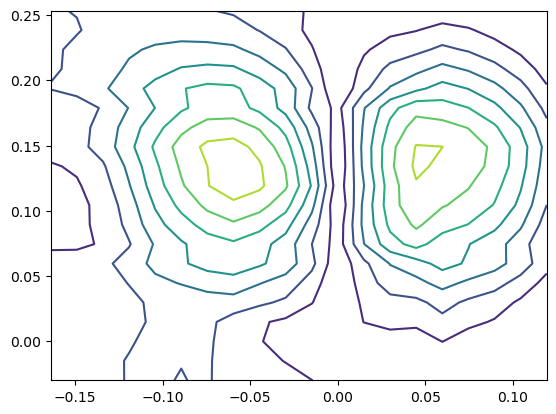

In [13]:
((test[10,:]-windowed_data[10,:])**2).mean()
plt.contour(X,Y,np.abs(test-windowed_data))

In [14]:
print(stats.shapiro(windowed_data[10,:]))


ShapiroResult(statistic=np.float64(0.9165412373703085), pvalue=np.float64(0.08501888633904407))


In [15]:
np.sqrt(np.mean((windowed_data/np.max(windowed_data)-fit_data/np.max(fit_data))**2))

np.float64(0.04441524392924229)

0.1642
  params: FitParams(loc=np.float64(0.11682582871363775), scale=np.float64(0.0680259921760892))
 success: True
 message: 'The fit was performed successfully.'


<Axes: title={'center': 'Fitted $\\tt norm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

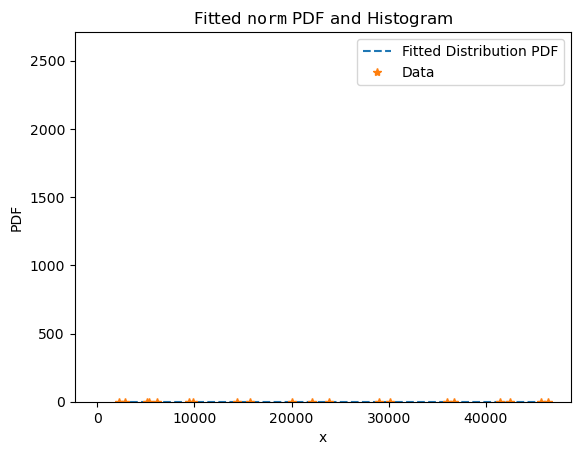

In [26]:
cuty = windowed_data[10,:]
fit_params_Y = {'loc': fitted.y_mean.value, 'scale':fitted.y_stddev.value}
gofY = stats.goodness_of_fit(stats.norm,cuty,fit_params=fit_params_Y)
print(gofY.pvalue)
print(gofY.fit_result)
plt.hist(np.log10(gofY.null_distribution))
gofY.fit_result.plot()

0.152
  params: FitParams(loc=np.float64(0.02132841789602008), scale=np.float64(0.057890024254291586))
 success: True
 message: 'The fit was performed successfully.'


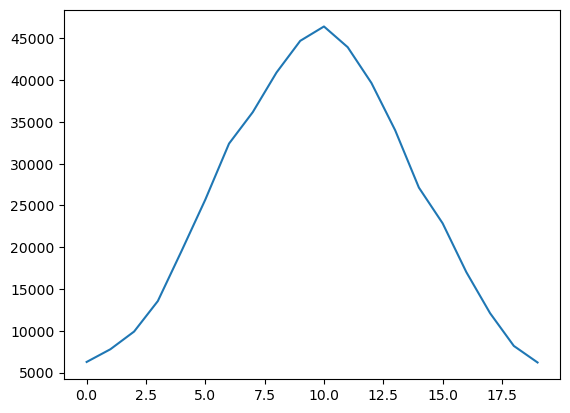

In [20]:
cutx = windowed_data[:,10]
fit_params_X = {'loc': fitted.x_mean.value, 'scale':fitted.x_stddev.value}
gofX = stats.goodness_of_fit(stats.norm,cutx,fit_params=fit_params_X)
print(gofX.pvalue)
print(gofX.fit_result)
#plt.hist(np.log10(gofX.null_distribution))
plt.plot(cutx)


<Axes: title={'center': 'Fitted $\\tt norm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

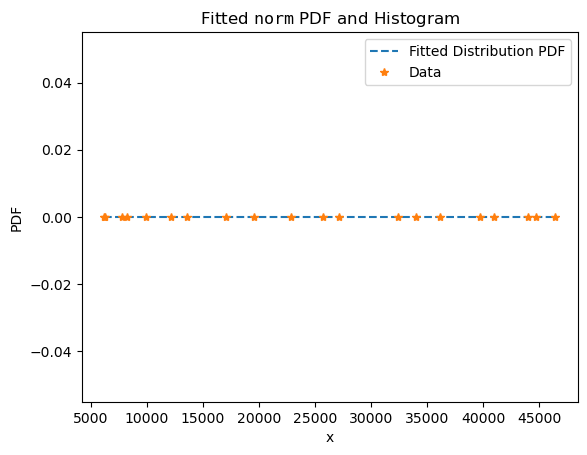

In [18]:
gof = stats.goodness_of_fit(stats.norm,cutx,fit_params=fit_params_X)
gof.fit_result.plot()